In [1]:
import sys
import torch
import pickle as pkl
import numpy as np
sys.path.append('../../../')

#from experiments.supervised.product_manifold.script import main, _plot_clusters, _plot_holonomy_dist, _plot_holonomy_surface
from models.supervised.mlp.model import MLP
from models.supervised.bimt.model import BioMLP


In [2]:
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
size = "2_wide"
mode = "moon"
model_name = "mlp"
epoch = 199
model = MLP(2,7,2,2)
models_path = f"../../../models/supervised/{model_name}/saved_models"

with open(f'{models_path}/2_wide/{mode}/dataset.pkl', 'rb') as f:
	dataset = pkl.load(f)

full_path = f'{models_path}/{size}/{mode}/model_{epoch}.pth'
model.load_state_dict(torch.load(full_path))
if size == "overfit":
	model.num_layers -= 1
	model.layers = model.layers[:-1]
model.eval()


In [ ]:
wrt = "layer_wise"
N=50
sigma = 0.05
X = torch.tensor(dataset.X).float()
holonomy_manifold, start_loop_vectors, loop_points = main(model, X, N, sigma, 0.9, wrt=wrt, K_MAX=10000)

In [ ]:
save_path = f"figures/{model_name}/{size}/{mode}/{epoch}"
_plot_holonomy_surface(holonomy_manifold, loop_points, X, dataset.y, wrt, save_path)
_plot_clusters(holonomy_manifold, loop_points, X, dataset.y, wrt, save_path)
_plot_holonomy_dist(holonomy_manifold, wrt, save_path)

In [ ]:
size = "vanilla"
mode = "moon"
model_name = "bimt"
epoch = 9999
model = BioMLP(shp=[2,20,20,2])
models_path = f"../../../models/supervised/{model_name}/saved_models"

with open(f'{models_path}/{size}/{mode}/dataset.pkl', 'rb') as f:
	dataset = pkl.load(f)

full_path = f'{models_path}/{size}/{mode}/model_{epoch}.pth'
model.load_state_dict(torch.load(full_path))
if size == "overfit":
	model.num_layers -= 1
	model.layers = model.layers[:-1]
model.eval()


In [ ]:
wrt = "layer_wise"
N=50
sigma = 0.05
X = torch.tensor(dataset.X).float()
holonomy_manifold, start_loop_vectors, loop_points = main(model, X, N, sigma, 0.9, wrt=wrt, K_MAX=10000)

In [ ]:
save_path = f"figures/{model_name}/{size}/{mode}/{epoch}"
print(save_path)
_plot_holonomy_surface(holonomy_manifold, loop_points, X, dataset.y, wrt, save_path)
_plot_clusters(holonomy_manifold, loop_points, X, dataset.y, wrt, save_path)
_plot_holonomy_dist(holonomy_manifold, wrt, save_path)

In [ ]:
tmp = np.unique(loop_points, axis=1)
import matplotlib.pyplot as plt
plt.scatter(tmp[0][:, 0], tmp[0][:, 1])
plt.scatter(dataset.X[:, 0], dataset.X[:, 1])

In [20]:
import os
from riemannian_geometry.computations.pullback_metric import pullback_holonomy
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import numpy as np

from collections import deque
import random
import networkx as nx
MIN_SAMPLES = 5

def find_cycles_random_walk(graph, K_max, max_walk_length=100):
    cycles = []
    vertices = list(graph.nodes())
    
    while len(cycles) < K_max:
        # Step 1: Choose a random starting vertex
        start_vertex = random.choice(vertices)
        
        # Steps 2-5: Perform the random walk to find a cycle
        visited = set()
        walk = deque()
        current_vertex = start_vertex
        last_vertex = None  # Keep track of the last visited vertex
        
        for _ in range(max_walk_length):
            visited.add(current_vertex)
            walk.append(current_vertex)
            
            # Step 3: Move to a randomly chosen neighbor, avoiding the last visited vertex
            neighbors = [n for n in graph.neighbors(current_vertex) if n != last_vertex]
            if not neighbors:
                break  # No valid neighbors to move to; terminate this walk
                
            last_vertex, current_vertex = current_vertex, random.choice(neighbors)
            
            # Step 4: Check if we've found a cycle
            if current_vertex == start_vertex:
                cycle = list(walk)
                cycles.append(cycle)
                break
            
            # Terminate the walk if it's a repeat vertex but not the start (not a simple cycle)
            if current_vertex in visited and current_vertex != start_vertex:
                break

    return cycles

def parallel_transport(P, X, Christoffel):
    """
    Approximate the parallel transport of a vector X along a path P with given Christoffel symbols.
    
    Parameters:
    - P: list of numpy arrays, representing the points on the path
    - X: numpy array, representing the initial vector at P[0]
    - Christoffel: list of 3D numpy arrays, representing the Christoffel symbols at each point P[i]
    
    Returns:
    - X_transported: numpy array, representing the parallel transported vector at the end of the path
    """
    # Initialize the transported vector as X
    X_transported = np.copy(X)
    
    # Iterate over the path
    for i in range(len(P) - 1):
        # Compute the finite difference between adjacent points
        delta_x = P[i + 1] - P[i]
        
        # Get the Christoffel symbols at the current point
        Gamma = Christoffel[i]
        
        # Update the transported vector using the Christoffel symbols and the finite difference
        for k in range(len(X)):
            delta_X_k = -np.sum(Gamma[k, :, :] * X_transported[:, np.newaxis] * delta_x[np.newaxis, :])
            X_transported[k] += delta_X_k
            
    return X_transported

def construct_knn_graph(points, k):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(points)
    _, indices = nbrs.kneighbors(points)
    graph = {}  # Initialize an empty graph
    for i, neighbors in enumerate(indices):
        graph[i] = list(neighbors[1:])
    return graph

def get_knn_graph(surface, max_K=20, verbose=False):
    if max_K is None:
        max_K = np.sqrt(len(surface)).astype(int)
        
    for k in range(2, max_K):
        knn_graph = construct_knn_graph(surface, k=k)


        G = nx.Graph()
        for u, nghbrs in knn_graph.items():
            for v in nghbrs:
                G.add_edge(u, v)
        sccs = list(nx.connected_components(G))
        if verbose:
            print(f"K={k} -> {len(sccs)}")
        if len(sccs) == 1:
            break
        if verbose:
            print(f"Nodes remaining: {sorted(sccs, key=lambda x: len(x))[0]}")
    return knn_graph

def find_best_dbscan_config(data, max_attempts=50, eps_range=(0.1, 1.0), min_samples_range=(5, 15)):
    """
    Attempts up to max_attempts configurations to find target_clusters using DBSCAN.
    Ranks configurations by the Silhouette score.
    
    Parameters:
    - data: numpy array, data to be clustered
    - target_clusters: int, the target number of clusters
    - max_attempts: int, maximum number of attempts
    - eps_range: tuple, range of eps values to try
    - min_samples_range: tuple, range of min_samples values to try
    
    Returns:
    - best_config: dict, best configuration parameters
    - best_score: float, best silhouette score
    """
    best_config = None
    best_score = -1  # Initialize with worst possible silhouette score

    for _ in range(max_attempts):
        # Randomly sample eps and min_samples within the given ranges
        eps = np.random.uniform(*eps_range)
        min_samples = np.random.randint(*min_samples_range)
        
        # Perform DBSCAN clustering
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
        labels = clustering.labels_
        
        # If the number of clusters is what we're looking for, evaluate using silhouette score
        if len(np.unique(labels)) > 1:
            score = silhouette_score(data, labels)
            if score > best_score:
                best_score = score
                best_config = {'eps': eps, 'min_samples': min_samples}
    if best_score == -1:
        best_config = {'eps': eps_range[0], 'min_samples': min_samples_range[0]}
        best_score = 0
    clustering = DBSCAN(eps=best_config['eps'], min_samples=best_config['min_samples']).fit(data)
    return clustering, best_config, best_score
import time

def get_holonomy_group(surface, input_surface, input_metric, input_Christoffel_Normed, V, quantile, EPS=.1, MIN_SAMPLES=5, K_MAX=100000):
    mask = np.abs(V) < np.quantile(np.abs(V), quantile)
    start_loop_vectors = []
    loop_points = []
    pruned_map = {}
    cnt = 0
    for k, v in enumerate(mask):
        if v:
            pruned_map[k] = cnt
            cnt += 1
    inv_pruned_map = {v: k for k, v in pruned_map.items()}
    _, start_vectors = np.linalg.eig(input_metric)
    pruned_surface = surface[mask]
    prune_input_surface = input_surface[mask]

    start = time.time()
    clustering, best_config, best_score =find_best_dbscan_config(pruned_surface)
    end = time.time()
    print(f"Clustering took {end - start} seconds. Best score: {best_score}. Best config: {best_config}")
    labels = clustering.labels_
    n_clusters_ = len(np.unique(labels))
    tmp = [prune_input_surface[labels==i] for i in range(n_clusters_)]
    segment_surface = np.array(tmp, dtype=object)
    segment_indices = {}
    for indx in range(len(pruned_surface)):
        segment_indices[indx] = labels[indx]
    holonomy_manifold = []
    for cluster in range(n_clusters_):
        if len(segment_surface[cluster]) < MIN_SAMPLES:
            continue
        holonomy_group_cluster = []
        cluster_start_vectors = []
        cluster_loop_points = []
        mappable_dict = {}
        cnt = 0
        start = time.time()
        for k, v in segment_indices.items():
            if v == cluster:
                mappable_dict[k] = cnt
                cnt += 1
        inv_mappable_dict = {v: k for k, v in mappable_dict.items()}
        G = nx.from_dict_of_lists(get_knn_graph(segment_surface[cluster]))

        cycles = find_cycles_random_walk(G, K_max = K_MAX//n_clusters_)
        end = time.time()
        print(f"Finding cycles took {end - start} seconds")

        start = time.time()
        for path in cycles:
            full_loop = path + [path[0]]
            points_path = input_surface[[inv_pruned_map[inv_mappable_dict[p]] for p in full_loop]]
            christoffel_path = input_Christoffel_Normed[[inv_pruned_map[inv_mappable_dict[p]] for p in full_loop]]
            start_vectors_loop = start_vectors[inv_pruned_map[inv_mappable_dict[path[0]]]]
            for start_vector in start_vectors_loop.T:
                transport_vector = parallel_transport(points_path, start_vector, christoffel_path)
                angle_diff = np.dot(transport_vector, start_vector) / (np.linalg.norm(transport_vector) * np.linalg.norm(start_vector))
                holonomy_group_cluster.append(angle_diff)
                cluster_start_vectors.append(start_vector)
                cluster_loop_points.append(points_path[0])
        holonomy_manifold.append(holonomy_group_cluster)
        start_loop_vectors.append(cluster_start_vectors)
        loop_points.append(cluster_loop_points)
        end = time.time()
        print(f"Computing holonomy group took {end - start} seconds. {(end-start)/len(cycles)} seconds per cycle")
    return holonomy_manifold, start_loop_vectors, loop_points

def _plot_holonomy_dist(holonomy_manifold, wrt, save_path):
    N_clusters = len(holonomy_manifold)
    fig, ax = plt.subplots(1, N_clusters, figsize=(N_clusters*8, 8))
    plot_holonomy_manifold = np.array(holonomy_manifold)
    total_size = np.prod(plot_holonomy_manifold.shape)

    tol = 1 - 1e-2
    mask = plot_holonomy_manifold < tol
    for i in range(N_clusters):
        ax[i].hist(plot_holonomy_manifold[i][mask[i]], bins=100)
        ax[i].set_title(f"Cluster {i} - Tol {tol} - Size {total_size}")
        ax[i].set_xlabel("Holonomy")
        ax[i].set_ylabel("Frequency")
    if os.path.isdir(f"{save_path}") == False:
        os.makedirs(f"{save_path}")
    plt.savefig(f"{save_path}/histogram_{wrt}.png")
    plt.close()

def _plot_holonomy_surface(holonomy_manifold, loop_points, X, labels, wrt, save_path):
    N_clusters = len(holonomy_manifold)
    plot_holonomy_manifold = np.array(holonomy_manifold)

    loop_points_plot = np.array(loop_points)
    min_c = plot_holonomy_manifold.min()
    max_c = plot_holonomy_manifold.max()
    for indx in range(N_clusters):
        color = plt.scatter(loop_points_plot[indx, :, 0], loop_points_plot[indx, :, 1], c=plot_holonomy_manifold[indx], cmap="RdBu_r", vmin=min_c, vmax=max_c)
    #color = plt.scatter(loop_points_plot[1][mask[1],0], loop_points_plot[1][mask[1],1], c=plot_holonomy_manifold[1,mask[1]], cmap="RdBu_r")
    plt.scatter(X[:,0], X[:,1], c=labels, cmap="viridis")
    plt.colorbar(color)
    if os.path.isdir(f"{save_path}") == False:
        os.makedirs(f"{save_path}")
    plt.savefig(f"{save_path}/surface_{wrt}.png")
    plt.close()

def _plot_clusters(holonomy_manifold, loop_points, X, labels, wrt, save_path):
    N_clusters = len(holonomy_manifold)
    loop_points_plot = np.array(loop_points)
    plot_unique = np.unique(loop_points_plot, axis=1)
    cmap = plt.cm.get_cmap('Accent', N_clusters)
    for indx in range(N_clusters):
        plt.scatter(plot_unique[indx, :, 0], plot_unique[indx, :, 1], label=f"Cluster {indx}", c=[cmap(indx)])

    plt.scatter(X[:,0], X[:,1], c=labels, cmap="RdBu_r")
    plt.legend(loc="upper right")
    if os.path.isdir(f"{save_path}") == False:
        os.makedirs(f"{save_path}")
    plt.savefig(f"{save_path}/clusters_{wrt}.png")
    plt.close()


def main(model, X, N, sigma, quantile, EPS=.1, MIN_SAMPLES=5, K_MAX=100000, wrt="output_wise"):
    model.forward(X, save_activations=True)
    activations = model.get_activations()
    # In pullback_metric_christoffel, we force the Christoffel symbols to be normalised as we primarily care about the direction.
    jacobian, output_g, g_pullback, Ricci_pullback, pullback_Christoffel,  input_surface, output_surface = pullback_holonomy(model, activations, N, wrt=wrt, method="manifold", sigma=sigma, normalised=False) 
    return jacobian, output_g, g_pullback, Ricci_pullback, pullback_Christoffel,  input_surface, output_surface

def main_2(input_surface, input_metric, input_Christoffel, output_surface, Ricci_pullback, quantile, EPS=.1, MIN_SAMPLES=5, K_MAX=100000):
    V = np.linalg.norm(Ricci_pullback, axis=(1,2), ord="fro")

    holonomy_manifold, start_loop_vectors, loop_points = get_holonomy_group(output_surface, input_surface, input_metric, input_Christoffel, V, quantile, EPS=EPS, MIN_SAMPLES=MIN_SAMPLES, K_MAX=K_MAX)
    return holonomy_manifold, start_loop_vectors, loop_points

In [ ]:
size = "mixup_vanilla"
mode = "blobs"
model_name = "mlp"
epoch = 199
#model = BioMLP(shp=[2,20,20,2])
model = MLP(2,7,10,4)
models_path = f"../../../models/supervised/{model_name}/saved_models"

with open(f'{models_path}/{size}/{mode}/dataset.pkl', 'rb') as f:
	dataset = pkl.load(f)

full_path = f'{models_path}/{size}/{mode}/model_{epoch}.pth'
model.load_state_dict(torch.load(full_path))
if size == "overfit":
	model.num_layers -= 1
	model.layers = model.layers[:-1]
model.eval()


In [95]:
wrt = "output_wise"
N=50
sigma = 0.05
X = torch.tensor(dataset.X).float()
jacobian, output_g, g_pullback, Ricci_pullback, pullback_Christoffel,  input_surface, output_surface = main(model, X, N, sigma, 0.9, wrt=wrt, K_MAX=10000)


torch.Size([1696, 2])
Jacobian computed in 0.012412309646606445 seconds
Jacobian converted to numpy in 0.0012989044189453125 seconds
Pullback metric computed in 0.0010249614715576172 seconds
Pullback Christoffel computed in 0.005940914154052734 seconds
Pullback Ricci computed in 0.001100778579711914 seconds


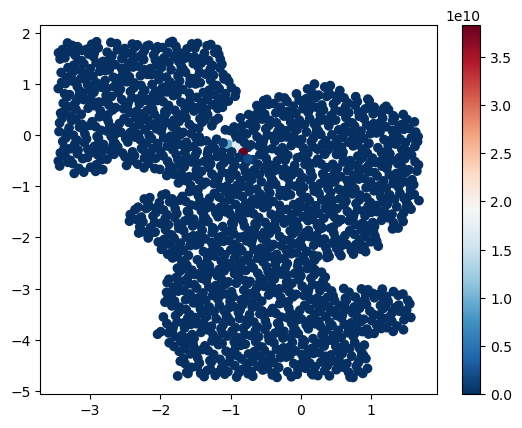

In [96]:
color = plt.scatter(input_surface[:,0], input_surface[:,1], c=np.linalg.det(g_pullback), cmap="RdBu_r")
#plt.scatter(dataset.X[:, 0], dataset.X[:, 1], c=dataset.y, cmap="viridis")
plt.colorbar(color)
plt.show()

(1695, 2)
(1695, 2, 2)


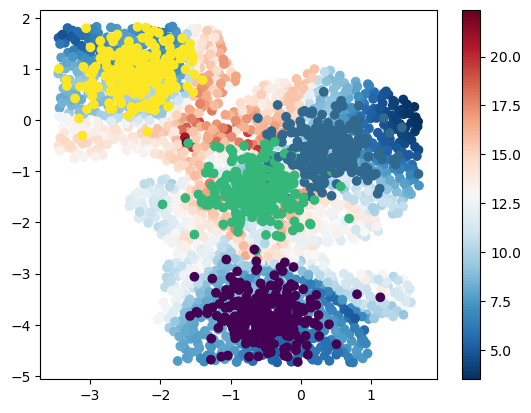

In [98]:
g_inv = np.linalg.inv(g_pullback)
S = np.einsum("Nij, Nij -> N", g_inv, Ricci_pullback) 
R_c = np.linalg.norm(Ricci_pullback, axis=(1,2), ord="fro")
J = np.linalg.norm(jacobian, axis=(1,2), ord=2)

quantile = np.quantile(np.linalg.norm(g_pullback, axis=(1,2), ord="fro"), 1)
mask = np.linalg.norm(g_pullback, axis=(1,2), ord="fro") < quantile 
g_pullback_mask = g_pullback[mask]
masked_S = S[mask] 
masked_R_c = R_c[mask] 
masked_surface = input_surface[mask] 
jacobian_masked = J[mask]

eigenvals, eigenvecs = np.linalg.eig(g_pullback_mask)
print(eigenvals.shape)
print(eigenvecs.shape)
color = plt.scatter(masked_surface[:,0], masked_surface[:,1],c=np.log(masked_R_c+1), cmap="RdBu_r")
plt.scatter(dataset.X[:, 0], dataset.X[:, 1], c=dataset.y, cmap="viridis")

#plt.quiver(masked_surface[:, 0], masked_surface[:, 1], eigenvals[:, 0]*eigenvecs[:, 0, 0], eigenvals[:, 0]*eigenvecs[:, 0, 1], color='r')
#plt.quiver(masked_surface[:, 0], masked_surface[:, 1], eigenvals[:, 1]*eigenvecs[:, 1, 0], eigenvals[:, 1]*eigenvecs[:, 1, 1], color='r')

plt.colorbar(color)
plt.show()

In [ ]:
quantile = 0.9
holonomy_manifold, start_loop_vectors, loop_points = main_2(g, surface, Christoffel_normed, quantile, EPS=.1, MIN_SAMPLES=5, K_MAX=100000)


In [ ]:
V = np.linalg.norm(g[0], axis=(1,2), ord='euc')
color = plt.scatter(surface[0][:, 0], surface[0][:, 1], c=V, cmap="RdBu_r", vmin=V.min(), vmax=V.max())
plt.scatter(dataset.X[:, 0], dataset.X[:, 1], c=dataset.y, cmap="viridis")
plt.colorbar(color)